## Customer Churn: Hurts Sales, Hurts Company
Customer churn refers to the situation when a customer ends their relationship with a company, and it’s a costly problem. 

<br>Customers are the fuel that powers a business. Loss of customers impacts sales. Further, it’s much more difficult and costly to gain new customers than it is to retain existing customers. As a result, organizations need to focus on reducing customer churn.

<br>This notebook will show you how to predict which customers are going to leave using machine learning.
## Data Description
The dataset used for this notebook is __[IBM Watson Telco Dataset](https://www.ibm.com/communities/analytics/watson-analytics-blog/predictive-insights-in-the-telco-customer-churn-data-set/)__. According to IBM, the business challenge is…

A telecommunications company Telco is concerned about the number of customers leaving their landline business for cable competitors. They need to understand who is leaving. Imagine that you’re an analyst at this company and you have to find out who is leaving and why.

The dataset includes information about:

Customers who left within the last month: The column is called Churn
Services that each customer has signed up for: phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information: how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers: gender, age range, and if they have partners and dependents
## Brief
This notebook is a great example of adopting machine learning to solve business problems. <br>

1.Deal with imbalanced data. Most business datasets are imbalanced, so it is critical to use oversampling or undersampling methods to reduce the imbalance. However, many data analysts fail to use these techniques because they conduct them in a wrong order. The consequence of wrong order is to "bleed" information to validation data and thus over estimate the performance. In this notebook, I use __SMOTE__ - Synthetic Minority Over-sampling Technique to deal with the imbalanced data, and make __pipelines__ to do __gridsearch__ with 10 fold cross-validation. <br>

2.Various feature engineering. For different kind of variables, we should use different transformation methods. In this notebook, I take __binning__ and __log transformation__ to deal with numerical variables. Also, it is important to test whether your transformation methods improve the correlation with classes.<br>

3.Evaluate models based on __business context__. There are various metrics to assess models. In this notebook, I demonstrate how to choose right metrics which fit your business context most to pick up a suitable model. For this business question, the most important thing is to identify potential churn customers. Therefore, we should improve the ratio of right prediction of churn customers. However, the actions to retain customers might cause costs, so we also need to avoid to give wrong alerts. Technically, we want a model with higher recall rate and precision rate for "1" . Recall (also true positive rate or specificity) is when the actual value is “yes” or "no", how often is the model correct. Therefore, I decide to use f1 score of "1" as the evaluation metric.

4.Decide and __customize__ evaluation metrics at the model building step. Although the model evaluation seems to be the next step of model building, please notice that we use gridsearch to choose the best hyperparameters, while we have to tell gridsearch the criteria of "best". Therefore, we have to think about the model evaluation metric at the model building step. Many analysts conduct gridsearch without setting evaluation metric and then choose the best model according to other metrics which they infer from "business context". This would reduce the productivity and reliability of the model.

## Result
The best models are __Gradient Boosting__ and __Gaussian Naive Bayes__, with f1 core 0.63 and 0.57 respectively. More specifically, the gradient boosting can predict 75% of churn customers and give 54% right alerts, while the gaussian naive bayes can predict 90% of churn customers and give 42% right alerts.

# Load Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv?cm_mc_uid=00893708416515157245786&cm_mc_sid_50200000=51435451522030121340&cm_mc_sid_52640000=50241551522030121347")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
#I notice that the "total charges" should be float instead of object, so let's change the format
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(2), ob

# Data Preprocessing

## Feature Engineering

In [7]:
#in this dataset, customer ID is a key to identify a unique customer, and do not affect churn, so we can delete it

In [8]:
df_new = df.iloc[:,1:]
df_new.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
#I notice that there are nulls in the "total charges" , and we can drop nulls directly since only 11 nulls exist
df_new.dropna(inplace=True)


In [10]:
#The first thing is to check whether the dataset is imbalanced
#here we can see that the data is imbalanced, so we need to transform it to balanced data in the later step
df_new["Churn"].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

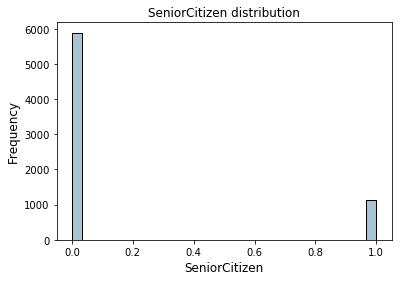

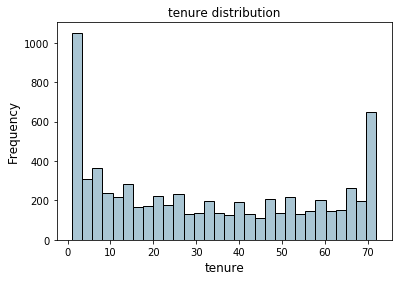

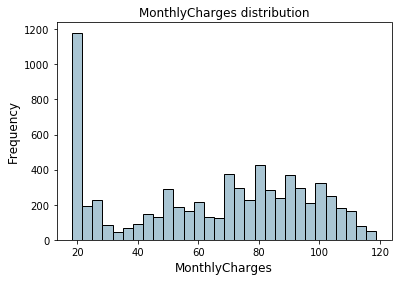

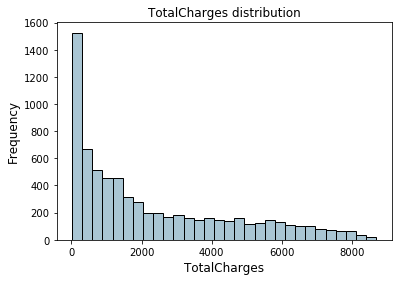

In [11]:
#Let's take a look at distribution of those numerical variables

for i in df_new.select_dtypes(exclude=['object']).columns:
    fig, ax = plt.subplots()
    df_new[i].hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
    ax.set_title(i+" distribution", fontsize=12)
    ax.set_xlabel(i, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    plt.show()
    
    

In [12]:
#For tenure, we can use bins to reduce the level of skew
#since the tenure is in month, we can use 12 as a bin to represent 1 year
df_new['tenure_t'] = np.array(np.floor(np.array(df_new['tenure']) / 12.))

In [13]:
#for monthly charges and total charges, we can use log transformation to even out the data into more of a normal distribution.
df_new['MonthlyCharges_t'] = np.log((1+ df_new['MonthlyCharges']))
df_new['TotalCharges_t'] = np.log((1+ df_new['TotalCharges']))

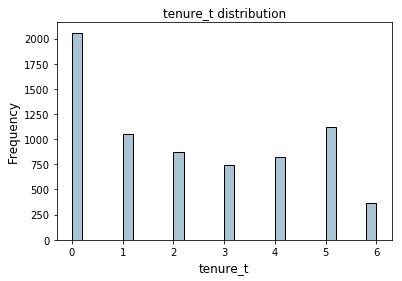

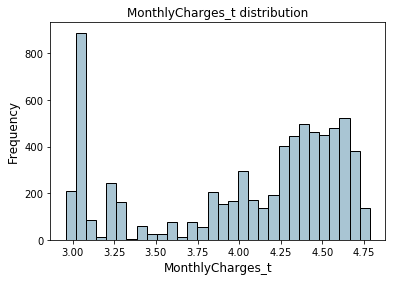

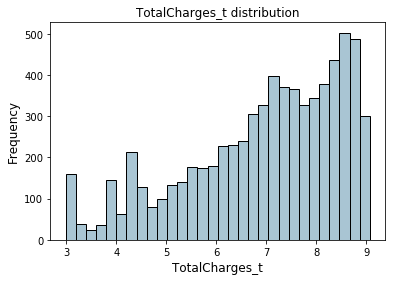

In [14]:
for i in ['tenure_t','MonthlyCharges_t','TotalCharges_t']:
    fig, ax = plt.subplots()
    df_new[i].hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
    ax.set_title(i+" distribution", fontsize=12)
    ax.set_xlabel(i, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    plt.show()

In [15]:
#To check whether our transformation methods work, we can examine whether the correlation increases after we adopt feature engineering
#from the result, we can know that both log transformation have positive effect, while the bin transformation has slightly negative effects.
#Let's use our transformation variables to go ahead
df_new["Churn"] = df_new["Churn"].map({"Yes":1,"No":0})
df_new.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,tenure_t,MonthlyCharges_t,TotalCharges_t
SeniorCitizen,1.000000,0.015683,0.219874,0.102411,0.150541,0.013069,0.216391,0.100838
tenure,0.015683,1.000000,0.246862,0.825880,-0.354049,0.989146,0.196934,0.833932
MonthlyCharges,0.219874,0.246862,1.000000,0.651065,0.192858,0.243943,0.977345,0.574763
TotalCharges,0.102411,0.825880,0.651065,1.000000,-0.199484,0.821152,0.586251,0.832262
Churn,0.150541,-0.354049,0.192858,-0.199484,1.000000,-0.343703,0.209690,-0.241908
tenure_t,0.013069,0.989146,0.243943,0.821152,-0.343703,1.000000,0.193962,0.805136
MonthlyCharges_t,0.216391,0.196934,0.977345,0.586251,0.209690,0.193962,1.000000,0.546079
TotalCharges_t,0.100838,0.833932,0.574763,0.832262,-0.241908,0.805136,0.546079,1.000000


In [16]:
df_m = df_new.drop(["tenure","MonthlyCharges","TotalCharges"],axis=1)

In [17]:
#Then let's deal with nominal variables, we can use get_dummy directly
df_t = pd.get_dummies(df_m,drop_first=True)

In [18]:
df_t.head()

,SeniorCitizen,Churn,tenure_t,MonthlyCharges_t,TotalCharges_t,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0.0,3.429137,3.429137,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,0,2.0,4.059581,7.544597,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,1,0.0,4.004602,4.692723,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0,3.0,3.768153,7.518471,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0.0,4.272491,5.028148,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


## Data Splitting

In [19]:
#divide input and output
X,y = df_t.drop("Churn",axis=1),df_t["Churn"]

In [20]:
#split train/test data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify = y, random_state=1)

## Feature Scaling

In [21]:
#Feature Scaling
#Here, we only scale those numerical variables, and since we have transform tenure to ordinal variable, we do not need to scale it
X_train_s = X_train[["MonthlyCharges_t","TotalCharges_t"]]
X_test_s = X_test[["MonthlyCharges_t","TotalCharges_t"]]


In [22]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train_s)
X_test_std = stdsc.transform(X_test_s)

In [23]:
# to merge the new std data with those categorical variables, we can transform the array to dataframe
#be careful about the row index
X_train_std = pd.DataFrame(X_train_std,columns=["MonthlyCharges_t","TotalCharges_t"],index=X_train.index)
X_test_std = pd.DataFrame(X_test_std,columns=["MonthlyCharges_t","TotalCharges_t"],index=X_test.index)

In [24]:
#here we have the scaled data and avoid to scale dummy variables
X_train_std = pd.concat([X_train_std, X_train.drop(["MonthlyCharges_t","TotalCharges_t"],axis=1)], axis=1)
X_test_std = pd.concat([X_test_std, X_test.drop(["MonthlyCharges_t","TotalCharges_t"],axis=1)], axis=1)

# Model Building

We already know that the data is imbalanced, so here we need to tackle this problem using SMOTE (Synthetic Minority Over-sampling Technique). And to make things simple, we build pipelines to do oversampling and classification. Then use Gridsearch to tune the hyperparameters.

In [174]:
# use SMOTE(Synthetic Minority Over-sampling Technique) to deal with imbalance
# build pipelines
#!pip install imblearn

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline,Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.svm import SVC

lr_pipeline = Pipeline([('smt', SMOTE(random_state=5, kind='borderline1', ratio ='auto')),
                        ('classifier', LR(random_state = 5))
                       ])

rf_pipeline = Pipeline([('smt', SMOTE(random_state=5, kind='borderline1', ratio ='auto')),
                        ('classifier', RF(n_estimators=20, random_state = 5))
                       ])

nb_pipeline = Pipeline([('smt', SMOTE(random_state=5, kind='borderline1', ratio ='auto')),
                        ('classifier', GNB())
                       ])

gb_pipeline = Pipeline([('smt', SMOTE(random_state=5, kind='borderline1', ratio ='auto')),
                        ('classifier', GBC(random_state = 5))
                       ])




## Set Model Evaluation Metric


Although the model evaluation seems to be the next step of model building, please notice that we use gridsearch to choose the best hyperparameters, while we have to tell gridsearch the criteria of "best". Therefore, we have to think about the model evaluation metric at the model building step.

There are no common rules for good metrics, while we have to dicide them according to business context. For this question, I think the most important thing is to find the potential churn customers and at the same time reduce the percentage of wrong "alerts". Therefore, I suggest to use the f1 score of label "1" as our evaluation metric.

However, the best way is to calculate the loss and gain of each part in the confusion matrix and then put up with a custom metric.

In [173]:
#This is to set the metric.
score = make_scorer(f1_score,labels = [1], average = "weighted")

In [146]:
#build grid search frames.

from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import recall_score, make_scorer,f1_score



#Grid search for logistic regression
lr_param_range = [ 0.001, 0.01, 0.1] 
lr_class_weight = [{0:0.01, 1:0.99}, {0:0.80, 1:0.20}]
lr_param_grid = [{'classifier__C':lr_param_range,
                'classifier__class_weight':lr_class_weight}]
gridsearch_lr = GridSearchCV(estimator = lr_pipeline,
                          param_grid = lr_param_grid,
                          n_jobs = -1,
                          cv = 10,scoring = score)

#Grid search for random forest
rf_class_weight = [{0:0.01, 1:0.99}, {0:0.10, 1:0.90}, {0:0.80, 1:0.20}]
rf_param_grid =[{'classifier__max_features': ["sqrt"],
                 'classifier__class_weight':rf_class_weight,
                 'classifier__min_samples_split': [100, 200],
                 'classifier__min_samples_leaf': [5, 10],
                 'classifier__n_estimators': [20, 50],
                 'classifier__criterion': ["entropy"]}] 
gridsearch_rf = GridSearchCV(estimator = rf_pipeline,
                          param_grid = rf_param_grid,
                          n_jobs = -1,
                          cv = 10,scoring = score)

#Grid search for Gradient Boosting Classifier
gb_param_grid = [{'classifier__n_estimators': [1000],
                  'classifier__min_samples_leaf': [9, 13],
                  'classifier__max_features': ['sqrt'],
                  'classifier__learning_rate': [0.05,  0.01],
                  }]
gridsearch_gb = GridSearchCV(estimator = gb_pipeline,
                          param_grid = gb_param_grid,
                          n_jobs = -1,
                          cv = 10,scoring = score)







After build the grid search frames, let's fit our train data, and save the best estimators to the disk so that we can load them directly next time without run the code again.

In [53]:
import dill

In [147]:

#best logistic regression model
gridsearch_lr.fit(X_train_std, y_train)
gridsearch_best_estimator_lr = gridsearch_lr.best_estimator_
dill.dump(gridsearch_best_estimator_lr, open('LogisticRegression_gridsearch_classweight.pkl', 'wb'))

#best random forest model
gridsearch_rf.fit(X_train_std, y_train)
gridsearch_best_estimator_rf= gridsearch_rf.best_estimator_
dill.dump(gridsearch_best_estimator_rf, open('RandomForest_gridsearch_classweight.pkl', 'wb'))

#best gradient boosting model
gridsearch_gb.fit(X_train_std, y_train)
gridsearch_best_estimator_gb = gridsearch_gb.best_estimator_
dill.dump(gridsearch_best_estimator_gb, open('GradientBoosting_gridsearch_classweight.pkl', 'wb'))



# Model Evaluation

We have saved the best estimators of each model at the last step. And please notice that those models are trained by oversampling data. Then we need to see whether they perform well on our original data. <br>
So let's run cross validation first to check the performance on training data, and then check the performance on testing data.

## Performance on Training Data

In [61]:
# this function is to draw the confusion matrix
def draw_ConfusionMatrix(conf_matrix, classifier_name):
    ''' The confusion matrix draw function'''
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Greens, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.title('Confusion Matrix for %s' % classifier_name)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

In [62]:

from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from scipy import interp

C:\Users\Mengyu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [66]:
# This function is to run cross validation on training data.
# Referrence:http://alexmwai.com/project/2016/08/02/loan2.html
def run_cv(X, y, classifier, clf_name):
    
    #Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    
    accuracy_scores = []
            
    #Initialize ROC variables
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    
    clf = classifier
    
    y_pred_full = y.copy()
    
    #Iterate through folds
    for i,(train_index, test_index) in enumerate(kf):
        
        #Obtain the training and validation data sets for each fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
                
        #Train the classifier on the training data
        clf_fit = clf.fit(X_train,y_train)
        
        #Obtain a prediction on the test set
        y_pred = clf_fit.predict(X_test)
        
        #Map the prediction for this fold to the full dataset
        y_pred_full.iloc[test_index] = y_pred
    
        #Calculate the accuracy of the prediction on current fold
        accuracy_scores.append(accuracy_score(y_true=y_test, y_pred=y_pred))
        
        #Get probabilities and compute area under ROC curve
        probas_ = clf_fit.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    #Get Evaluation metrics    
    #Draw ROC Curve    
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot([0, 1], 
             [0, 1], 
             '--', 
             color=(0.6, 0.6, 0.6), 
             label='Luck')
    
    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2,
             linestyle=':',
             color='black',
             label='Perfect Performance')
    
    plt.plot(mean_fpr, 
             mean_tpr, 
             'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for %s' % classifier_name)
    plt.legend(loc="lower right")
    #plt.tight_layout()
    plt.show()
    
    #Accuracy score
    mean = np.mean(accuracy_scores)
    std = np.std(accuracy_scores)
    print(clf_name + ':' + '\n' + 'cross-validation accuracy')
    print ("%.2f +/- %.3f" % (mean, std))
    print (classification_report(y, y_pred_full))
    
    #Confusion Matrix
    conf_matrix = confusion_matrix(y_true=y, y_pred=y_pred_full)
    draw_ConfusionMatrix(conf_matrix, clf_name)
    
    return clf_fit

In [152]:
# Here, let's read our saved models!

import dill
with open('LogisticRegression_gridsearch_classweight.pkl', 'rb') as f:
    LogisticRegression_classifier = dill.load(f)
with open('RandomForest_gridsearch_classweight.pkl', 'rb') as f:
    RandomForest_classifier = dill.load(f)
with open('GradientBoosting_gridsearch_classweight.pkl', 'rb') as f:
    GradientBoosting_classifier = dill.load(f)

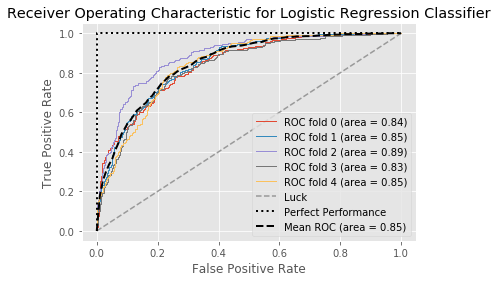

Logistic Regression Classifier:
cross-validation accuracy
0.80 +/- 0.011
             precision    recall  f1-score   support

          0       0.81      0.95      0.87      3614
          1       0.72      0.39      0.50      1308

avg / total       0.79      0.80      0.77      4922



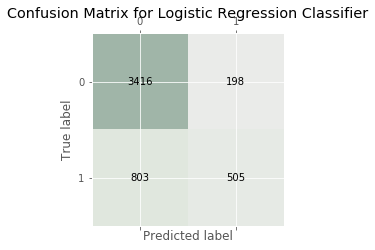

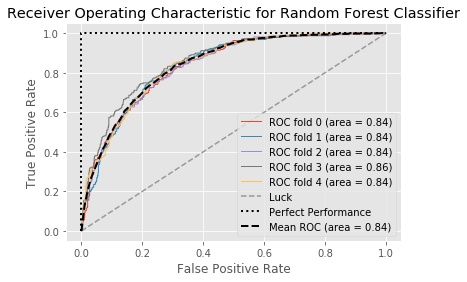

Random Forest Classifier:
cross-validation accuracy
0.55 +/- 0.018
             precision    recall  f1-score   support

          0       0.98      0.39      0.56      3614
          1       0.37      0.98      0.53      1308

avg / total       0.82      0.55      0.55      4922



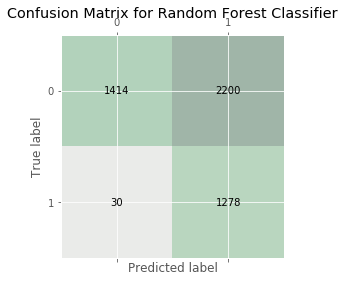

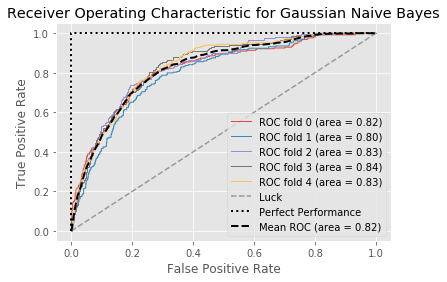

Gaussian Naive Bayes:
cross-validation accuracy
0.64 +/- 0.017
             precision    recall  f1-score   support

          0       0.94      0.55      0.69      3614
          1       0.42      0.90      0.57      1308

avg / total       0.80      0.64      0.66      4922



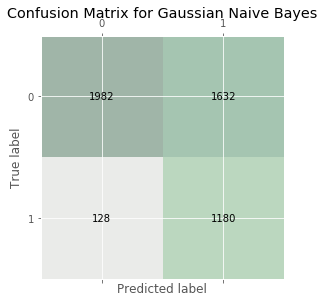

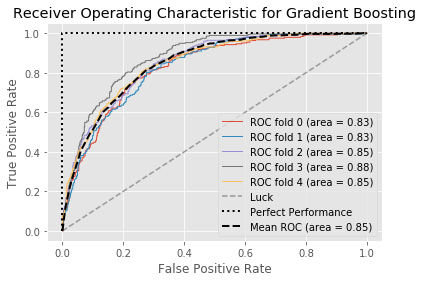

Gradient Boosting:
cross-validation accuracy
0.76 +/- 0.019
             precision    recall  f1-score   support

          0       0.89      0.77      0.83      3614
          1       0.54      0.75      0.63      1308

avg / total       0.80      0.76      0.77      4922



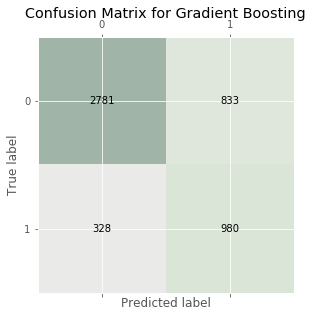

In [153]:
# run the cross validation
# Note that in the run_cv function, we return the clf_fit, which is the model containing both hyperparameters and parameters 
#that fit the training data
classifier_name = 'Logistic Regression Classifier'
model_pipeline_lr = run_cv(X_train_std, y_train, LogisticRegression_classifier, classifier_name)

classifier_name = 'Random Forest Classifier'
model_pipeline_rf = run_cv(X_train_std, y_train, RandomForest_classifier, classifier_name)
dill.dump(model_pipeline_rf, open('RandomForest_model_AllFeatures.pkl', 'wb'))

classifier_name = 'Gaussian Naive Bayes'
GaussianNB_classifier = nb_pipeline
model_pipeline_nb = run_cv(X_train_std, y_train, GaussianNB_classifier, classifier_name)

classifier_name = 'Gradient Boosting'
model_pipeline_gb = run_cv(X_train_std, y_train, GradientBoosting_classifier, classifier_name)

## Model Selection

As we discussed before, in this notebook I choose f1 score of label "1" as the evaluation metric, so the Gradient Boosting and Gaussian Naive Bayes are two of the best models.

## Performance on Test Data

In [165]:
#Then let's take a look at the performance of the two models on test data.
print("Performance of Gaussian Naive Bayes on Test Data")
print('Test accuracy: %.2f' % (model_pipeline_nb.score(X_test_std, y_test)))
print('Test classification report')
print(classification_report(y_test, model_pipeline_nb.predict(X_test_std)))

Performance of Gaussian Naive Bayes on Test Data
Test accuracy: 0.63
Test classification report
             precision    recall  f1-score   support

          0       0.93      0.54      0.68      1549
          1       0.41      0.88      0.56       561

avg / total       0.79      0.63      0.65      2110



In [164]:
print("Performance of Gradient Boosting on Test Data")
print('Test accuracy: %.2f' % (model_pipeline_gb.score(X_test_std, y_test)))
print('Test classification report')
print(classification_report(y_test, model_pipeline_gb.predict(X_test_std)))

Performance of Gradient Boosting on Test Data
Test accuracy: 0.76
Test classification report
             precision    recall  f1-score   support

          0       0.90      0.76      0.82      1549
          1       0.54      0.76      0.63       561

avg / total       0.80      0.76      0.77      2110



The result shows that the two models do not have overfitting problems. They are ready to go! And as for which one to take, we can get a function of profit, and then optimize it. This process would be easy even for a middle school student, so we are not going to talk about this.

# Feature Interpretation 

Although we've gotten a descent model, business people might also want to know what factors influence the customer churn most. We can use random forest to interpret the importance of features in terms of customer churn.

In [166]:
# read the random forest model that we have fitted on training data
with open('RandomForest_model_AllFeatures.pkl', 'rb') as f:
    model_pipeline_rf = dill.load(f)

In [167]:
# get the random forest part from the pipeline object
classifier = model_pipeline_rf.steps[-1]
forest = classifier[1]

In [168]:
# get the importances of features
importances = forest.feature_importances_

In [169]:
# calculate the standard deviation in the feature importance for each tree of the random forest
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

In [170]:
# obtain the indices that will sort the importances array starting with the most important feature
indices = np.argsort(importances)[::-1]

In [171]:
# get the list of features
features = X_train_std.columns

1 Contract_Two year 0.190726264952
2 TotalCharges_t 0.104269943339
3 tenure_t 0.0950190477351
4 Contract_One year 0.0817435829286
5 MonthlyCharges_t 0.062750071098
6 InternetService_Fiber optic 0.0537984245959
7 PaymentMethod_Electronic check 0.0510676285439
8 OnlineSecurity_Yes 0.043908260733
9 TechSupport_Yes 0.0425681289812
10 Dependents_Yes 0.0275726245642
11 OnlineBackup_No internet service 0.0242960956084
12 InternetService_No 0.0237622621839
13 PaperlessBilling_Yes 0.0183526117789
14 OnlineSecurity_No internet service 0.0180460854445
15 OnlineBackup_Yes 0.0176342072076
16 StreamingMovies_Yes 0.0172039149385
17 Partner_Yes 0.0159686737788
18 StreamingTV_No internet service 0.0155656240847
19 PaymentMethod_Credit card (automatic) 0.0129272706246
20 PaymentMethod_Mailed check 0.0126631659402
21 MultipleLines_Yes 0.0111934877254
22 DeviceProtection_Yes 0.00995586969429
23 TechSupport_No internet service 0.00984259824996
24 StreamingMovies_No internet service 0.00894816874754
25 gend

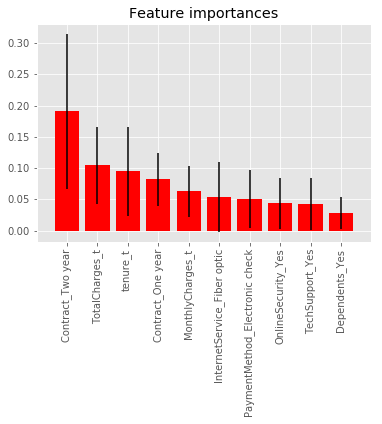

In [172]:
# list the importance of each feature and draw the top ten features.
for f in range(X_train_std.shape[1]):
    print(f+1, features[indices[f]], importances[indices[f]])
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[:10]], yerr=std[indices[:10]], color="r", align="center")
plt.xticks(rotation=90)
plt.xticks(range(10), features[indices[:10]])
plt.xlim([-1, 10])
plt.show()

# More Questions

Let's see what will happen if we remove SMOTE.

In [157]:

# build pipelines without SMOTE




lr_pipeline = Pipeline([
                        ('classifier', LR(random_state = 5))
                       ])

rf_pipeline = Pipeline([
                        ('classifier', RF(n_estimators=20, random_state = 5))
                       ])

nb_pipeline = Pipeline([
                        ('classifier', GNB())
                       ])

gb_pipeline = Pipeline([
                        ('classifier', GBC(random_state = 5))
                       ])




In [158]:
#build grid search frames.

from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import recall_score, make_scorer,f1_score

score = make_scorer(f1_score,labels = [0], average = "weighted")

#Grid search for logistic regression
lr_param_range = [ 0.001, 0.01, 0.1] 
lr_class_weight = [{0:0.01, 1:0.99}, {0:0.80, 1:0.20}]
lr_param_grid = [{'classifier__C':lr_param_range,
                'classifier__class_weight':lr_class_weight}]
gridsearch_lr = GridSearchCV(estimator = lr_pipeline,
                          param_grid = lr_param_grid,
                          n_jobs = -1,
                          cv = 10,scoring = score)

#Grid search for random forest
rf_class_weight = [{0:0.01, 1:0.99}, {0:0.10, 1:0.90}, {0:0.80, 1:0.20}]
rf_param_grid =[{'classifier__max_features': ["sqrt"],
                 'classifier__class_weight':rf_class_weight,
                 'classifier__min_samples_split': [100, 200],
                 'classifier__min_samples_leaf': [5, 10],
                 'classifier__n_estimators': [20, 50],
                 'classifier__criterion': ["entropy"]}] 
gridsearch_rf = GridSearchCV(estimator = rf_pipeline,
                          param_grid = rf_param_grid,
                          n_jobs = -1,
                          cv = 10,scoring = score)

#Grid search for Gradient Boosting Classifier
gb_param_grid = [{'classifier__n_estimators': [1000],
                  'classifier__min_samples_leaf': [9, 13],
                  'classifier__max_features': ['sqrt'],
                  'classifier__learning_rate': [0.05,  0.01],
                  }]
gridsearch_gb = GridSearchCV(estimator = gb_pipeline,
                          param_grid = gb_param_grid,
                          n_jobs = -1,
                          cv = 10,scoring = score)




After build the grid search frames, let's fit our train data.

In [159]:

#best logistic regression model
gridsearch_lr.fit(X_train_std, y_train)
gridsearch_best_estimator_lr = gridsearch_lr.best_estimator_


#best random forest model
gridsearch_rf.fit(X_train_std, y_train)
gridsearch_best_estimator_rf= gridsearch_rf.best_estimator_


#best gradient boosting model
gridsearch_gb.fit(X_train_std, y_train)
gridsearch_best_estimator_gb = gridsearch_gb.best_estimator_


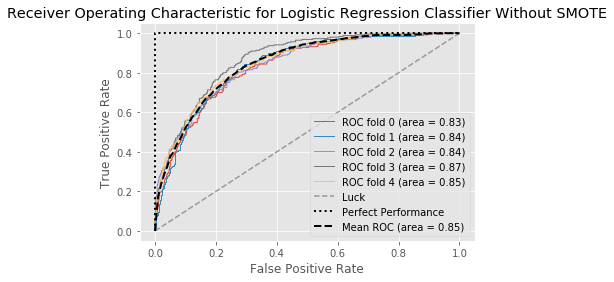

Logistic Regression Classifier Without SMOTE:
cross-validation accuracy
0.75 +/- 0.011
             precision    recall  f1-score   support

          0       0.75      1.00      0.85      3614
          1       0.88      0.06      0.12      1308

avg / total       0.78      0.75      0.66      4922



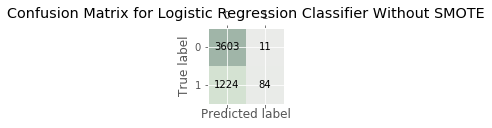

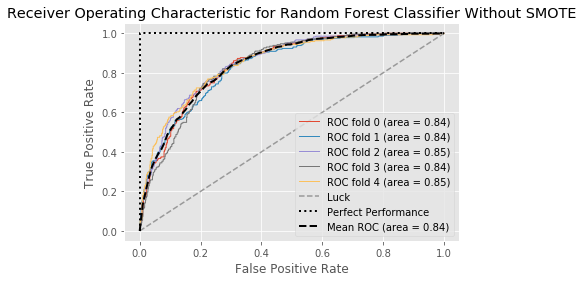

Random Forest Classifier Without SMOTE:
cross-validation accuracy
0.74 +/- 0.010
             precision    recall  f1-score   support

          0       0.74      1.00      0.85      3614
          1       0.82      0.04      0.07      1308

avg / total       0.76      0.74      0.64      4922



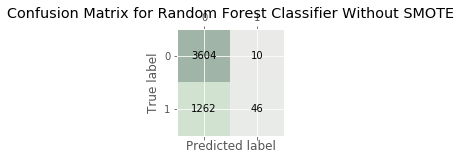

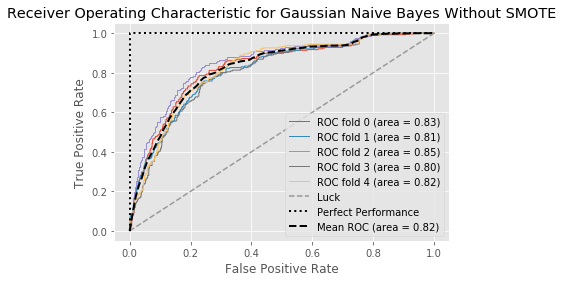

Gaussian Naive Bayes Without SMOTE:
cross-validation accuracy
0.67 +/- 0.025
             precision    recall  f1-score   support

          0       0.93      0.59      0.72      3614
          1       0.44      0.88      0.59      1308

avg / total       0.80      0.67      0.69      4922



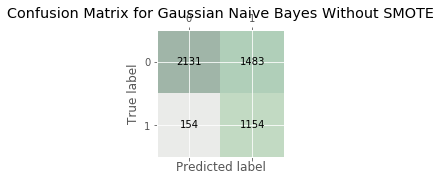

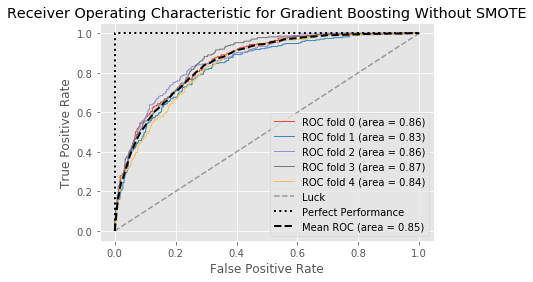

Gradient Boosting Without SMOTE:
cross-validation accuracy
0.80 +/- 0.011
             precision    recall  f1-score   support

          0       0.84      0.90      0.87      3614
          1       0.66      0.53      0.59      1308

avg / total       0.79      0.80      0.80      4922



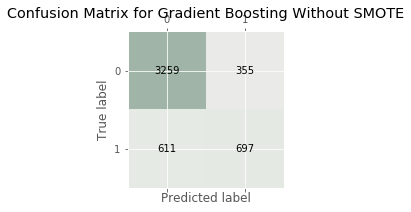

In [161]:
# run the cross validation
# Note that in the run_cv function, we return the clf_fit, which is the model containing both hyperparameters and parameters 
#that fit the training data
classifier_name = 'Logistic Regression Classifier Without SMOTE'
model_pipeline_lr_noSMOTE = run_cv(X_train_std, y_train, gridsearch_best_estimator_lr, classifier_name)

classifier_name = 'Random Forest Classifier Without SMOTE'
model_pipeline_rf_noSMOTE = run_cv(X_train_std, y_train, gridsearch_best_estimator_rf, classifier_name)
dill.dump(model_pipeline_rf, open('RandomForest_model_AllFeatures.pkl', 'wb'))

classifier_name = 'Gaussian Naive Bayes Without SMOTE'
GaussianNB_classifier = nb_pipeline
model_pipeline_nb_noSMOTE = run_cv(X_train_std, y_train, GaussianNB_classifier, classifier_name)

classifier_name = 'Gradient Boosting Without SMOTE'
model_pipeline_gb_noSMOTE = run_cv(X_train_std, y_train, gridsearch_best_estimator_gb, classifier_name)


In [162]:
#Then let's take a look at the performance of the two models on test data.
print("Performance of Gaussian Naive Bayes without SMOTE on Test Data")
print('Test accuracy: %.2f' % (model_pipeline_nb_noSMOTE.score(X_test_std, y_test)))
print('Test classification report')
print(classification_report(y_test, model_pipeline_nb_noSMOTE.predict(X_test_std)))

Performance of Gaussian Naive Bayes without SMOTE on Test Data
Test accuracy: 0.65
Test classification report
             precision    recall  f1-score   support

          0       0.92      0.58      0.71      1549
          1       0.42      0.86      0.57       561

avg / total       0.79      0.65      0.67      2110



In [163]:
print("Performance of Gradient Boosting without SMOTE on Test Data")
print('Test accuracy: %.2f' % (model_pipeline_gb_noSMOTE.score(X_test_std, y_test)))
print('Test classification report')
print(classification_report(y_test, model_pipeline_gb_noSMOTE.predict(X_test_std)))

Performance of Gradient Boosting without SMOTE on Test Data
Test accuracy: 0.81
Test classification report
             precision    recall  f1-score   support

          0       0.84      0.91      0.87      1549
          1       0.68      0.53      0.60       561

avg / total       0.80      0.81      0.80      2110



It's obvious that SMOTE does have influence on the model performance, but we cannot make sure whether the influence is positive or negative. I think the reason is that we set the f1 score of label '1' as the evaluation metric, so when we use oversampling method, sometimes the model has to classify more "0" to 1 to achieve the highest metric, because there are more "1" labels that are similar to "0". You can uderstand this by following pictures. If we set the evaluation metric as accuracy or the overall f1 score, SMOTE method will show its power.<img src='http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_comparison_over_sampling_003.png'> 